In [1]:
import sys
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
#connect local PATH
p = os.path.abspath(r'C:\Users\Ben\Desktop\Diplomatiki')
sys.path.append(str(p))

from CryptoSent.tools import utils as cs


#models
#from CryptoSent.cs_models.distilbert import distil_bert_df,distil_bert
from CryptoSent.tools.crypto_coin_actual import get_btc_actual_hourly
from CryptoSent.tools import evaluation as eval
#from CryptoSent.cs_models.finbertlong import fin_bert_long
#from CryptoSent.cs_models.distilbert import distil_bert

ModuleNotFoundError: No module named 'praw'

In [1]:
#from platform import dist
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
tqdm.pandas()


tokenizer_distil = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model_distil = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

def distil_bert(x, output='probs'):
    """
    Return Negative first and Positive after
    """
    tokens = tokenizer_distil.encode_plus(x, add_special_tokens=True,return_tensors='pt')
    outputs = model_distil(**tokens)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    neg,pos = probs[0][0].item(), probs[0][1].item()
    if output == 'probs':
        return neg,pos
    else:
        return pos-neg


def distil_bert_df(df,text,output_type='probs'):
    if output_type == 'probs':
        temp=df[text].progress_apply(lambda x: distil_bert(x,output=output_type));
        #df['neg_db']=temp.apply(lambda x: x[0])
        #df['pos_db']=temp.apply(lambda x: x[1])
        df.loc[:,'neg_db']=temp.apply(lambda x: x[0])
        df.loc[:,'pos_db']=temp.apply(lambda x: x[1])
        return df
    else:
       df['sent_db']=df[text].progress_apply(lambda x: distil_bert(x,output=output_type));
       return df

ImportError: cannot import name 'TFPreTrainedModel' from 'transformers' (C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\transformers\__init__.py)

In [2]:
btc=get_btc_actual_hourly()

100%|██████████| 30907/30907 [00:00<00:00, 166850.75it/s]


In [2]:
p=r'C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\Main Dataset\submissions.pickle'
df=pd.read_pickle(p)

# selecting btc only
df=df[df.subreddit=='Bitcoin']
df=df.sort_values(by='score',ascending=False)
top=df.head(1000)

In [17]:
top=distil_bert_df(top,'title','sentiment')

100%|██████████| 100000/100000 [35:11<00:00, 47.36it/s]
C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\cs_models\distilbert.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Load top100K btc


In [3]:
top=pd.read_pickle(r'C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\other\btc_subs_top100k.pickle')

In [4]:
eval.get_ts_2axis(top.sent_db,btc.avg_hl,resample_period='w',btc_transformation='pct_change')

## Experts KPI

In [5]:
def get_experts(df):
    df.award_count=df.award_count.replace('Empty',0)
    df.award_coin_price=df.award_coin_price.replace('Empty',0)
    df['kpi1']=df.apply(lambda row: row['award_count']*row['award_coin_price'] if type(row['award_count'])==int
                                            else sum(np.multiply(np.array(list(row['award_count'])),np.array(list(row['award_coin_price'])))),axis=1)

    #top_authors=df[df.author!='[deleted]'].sort_values(by='kpi1',ascending=False).head(1000).author.unique().tolist()
    #return top_authors
    #top_authors_df=top[top.author.isin(get_experts(top))]
get_experts(top)
qa=top[['kpi1','score','num_comments','sent_db','id']]
qa=qa.replace(0,1)
qa['influence']=np.log((qa.kpi1*qa.score*qa.num_comments))
qa['kpi2']=np.log((qa.kpi1*qa.score*qa.num_comments))*qa.sent_db
qa=qa.sort_values(by='influence',ascending=False)

In [6]:
qa

,kpi1,score,num_comments,sent_db,id,influence,kpi2
created,,,,,,,
2021-02-08 13:48:45,25205,45445,2954,-0.834298,lfb3mm,28.849971,-24.069481
2021-02-18 08:23:21,29050,13814,3684,-0.973788,lmgsnj,28.021966,-27.287463
2021-05-16 20:34:03,26480,16814,3065,-0.998624,ndunlj,27.941915,-27.903455
2021-05-19 13:50:39,28365,24236,1177,-0.999085,ng3otr,27.419230,-27.394153
2021-01-07 11:50:33,73505,13347,683,0.999705,ksay65,27.230650,27.222607
...,...,...,...,...,...,...,...
2019-08-18 01:37:23,1,2,1,-0.926497,crtr3y,0.693147,-0.642199
2019-04-09 17:40:11,1,2,1,0.944449,bb9f0p,0.693147,0.654642
2020-02-18 12:16:19,1,2,1,-0.993006,f5q9t4,0.693147,-0.688299


In [40]:
eval.get_ts_2axis(top.sent_db,btc.avg_hl,resample_period='w',btc_transformation='pct_change')

In [13]:
eval.get_ts_2axis(qa.head(10000).kpi2,btc.avg_hl,resample_period='w',btc_transformation='pct_change')

In [42]:
eval.get_ts_2axis(qa.tail(10000).kpi2,btc.avg_hl,resample_period='d',btc_transformation='pct_change')

C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



<AxesSubplot:>

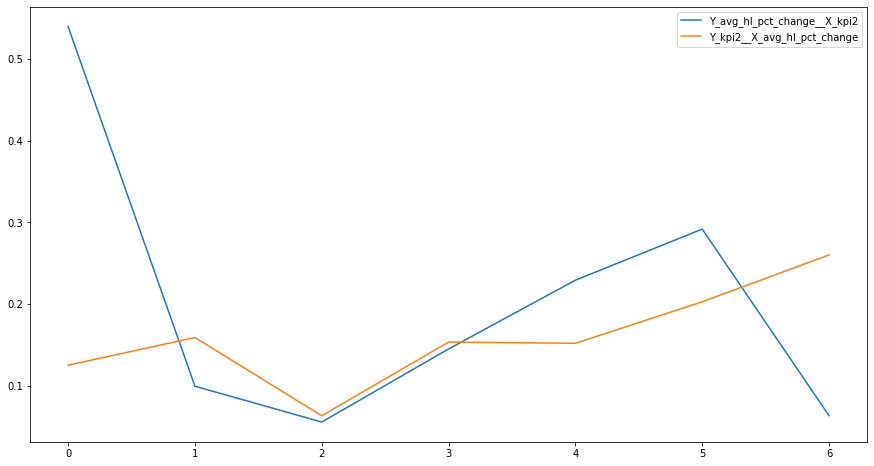

In [36]:
res=eval.result_processing(qa['2020-05':].head(10000).kpi2,btc.avg_hl,resample_period='d')
inm=res[['kpi2','avg_hl_pct_change']].dropna()
eval.get_granger_causality(inm,maxlag=7).plot(figsize=(15,8))


# Granger Causality

<AxesSubplot:>

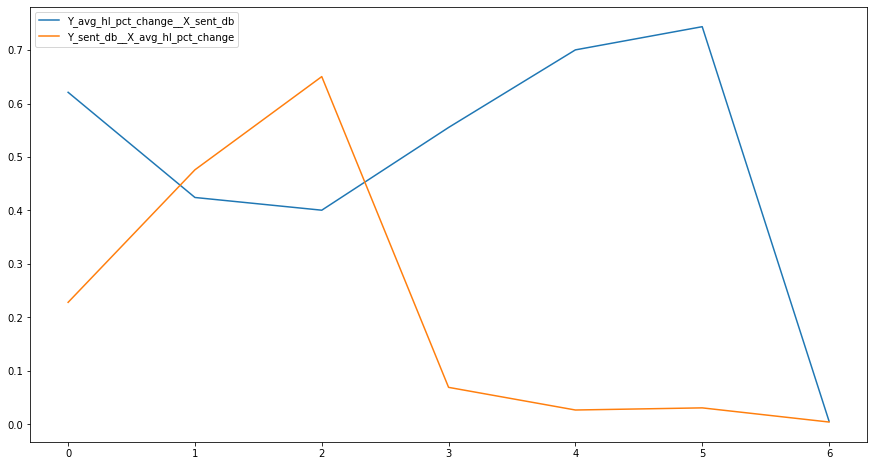

In [23]:
res=eval.result_processing(top.sent_db,btc.avg_hl,resample_period='d')
inm=res[['sent_db','avg_hl_pct_change']].dropna()
eval.get_granger_causality(inm,maxlag=7).plot(figsize=(15,8))

In [24]:
df=top.copy()
df.award_count=df.award_count.replace('Empty',0)
df.award_coin_price=df.award_coin_price.replace('Empty',0)
df['kpi1']=df.apply(lambda row: row['award_count']*row['award_coin_price'] if type(row['award_count'])==int
                                        else sum(np.multiply(np.array(list(row['award_count'])),np.array(list(row['award_coin_price'])))),axis=1)

top_authors=df[df.author!='[deleted]'].sort_values(by='kpi1',ascending=False).head(1000).author.unique().tolist()
top_authors_df=df[df.author.isin(top_authors)]
bottom_authors_df=df[~df.author.isin(top_authors)]

<AxesSubplot:>

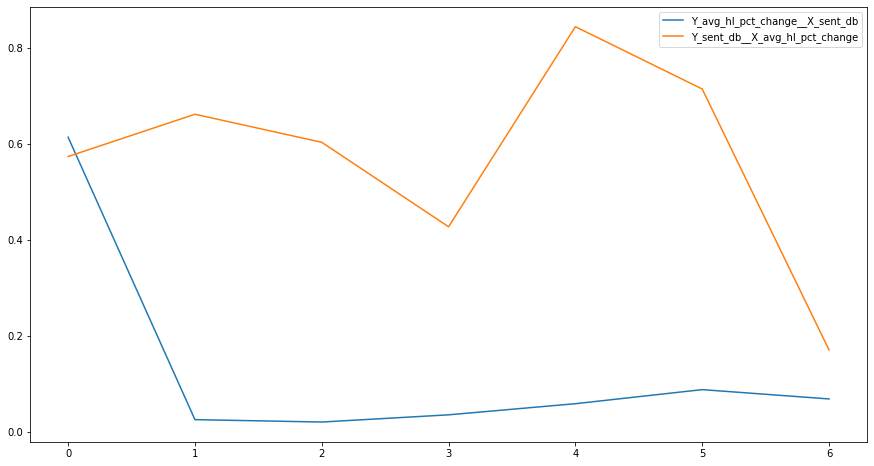

In [39]:
res=eval.result_processing(top_authors_df.sent_db,btc.avg_hl,resample_period='d')
inm=res[['sent_db','avg_hl_pct_change']].dropna()
eval.get_granger_causality(inm,maxlag=7).plot(figsize=(15,8))

<AxesSubplot:>

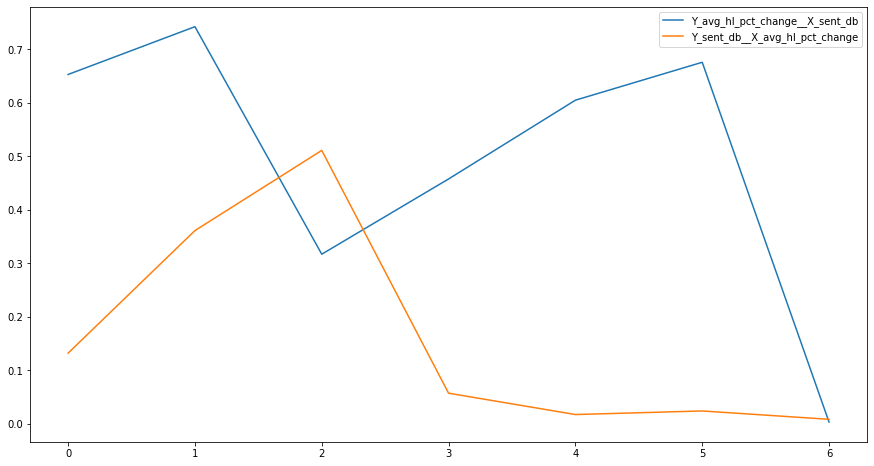

In [31]:
res=eval.result_processing(bottom_authors_df.sent_db,btc.avg_hl,resample_period='d')
inm=res[['sent_db','avg_hl_pct_change']].dropna()
eval.get_granger_causality(inm,maxlag=7).plot(figsize=(15,8))

<AxesSubplot:>

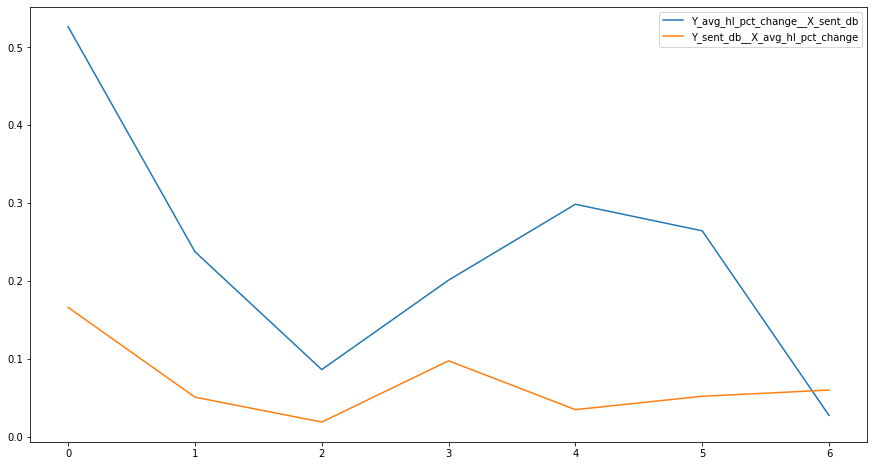

In [22]:
res=eval.result_processing(df.sort_values(by='kpi1',ascending=False).head(10000).sent_db,btc.avg_hl,resample_period='d')
inm=res[['sent_db','avg_hl_pct_change']].dropna()
eval.get_granger_causality(inm,maxlag=7).plot(figsize=(15,8))

<AxesSubplot:>

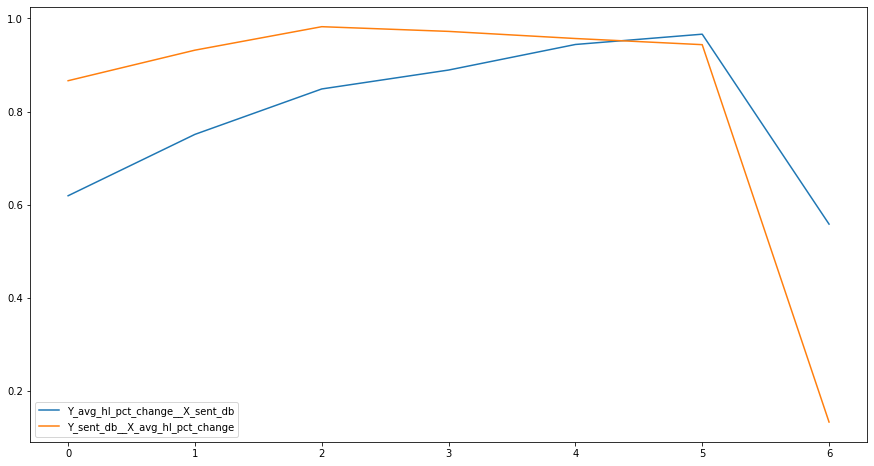

In [23]:
res=eval.result_processing(df.sort_values(by='kpi1',ascending=False).tail(10000).sent_db,btc.avg_hl,resample_period='d')
inm=res[['sent_db','avg_hl_pct_change']].dropna()
eval.get_granger_causality(inm,maxlag=7).plot(figsize=(15,8))

# MultiVariete fbprophet

In [2]:
import pandas as pd
from fbprophet import Prophet


In [3]:
df_lr=pd.read_pickle(r"C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Sentiment Models\subs_lr_sent.pickle")

In [4]:
def get_experts(df):
    df.award_count=df.award_count.replace('Empty',0)
    df.award_coin_price=df.award_coin_price.replace('Empty',0)
    df['kpi1']=df.apply(lambda row: row['award_count']*row['award_coin_price'] if type(row['award_count'])==int
                                            else sum(np.multiply(np.array(list(row['award_count'])),np.array(list(row['award_coin_price'])))),axis=1)

    #top_authors=df[df.author!='[deleted]'].sort_values(by='kpi1',ascending=False).head(1000).author.unique().tolist()
    #return top_authors
    #top_authors_df=top[top.author.isin(get_experts(top))]
get_experts(df_lr)
qa=df_lr[['kpi1','score','num_comments','polarity_lr','id']]
qa=qa.replace(0,1)
qa['influence']=np.log((qa.kpi1*qa.score*qa.num_comments))
qa['kpi2']=np.log((qa.kpi1*qa.score*qa.num_comments))*qa.polarity_lr
qa=qa.sort_values(by='influence',ascending=False)

In [5]:
qa

,kpi1,score,num_comments,polarity_lr,id,influence,kpi2
created,,,,,,,
2021-04-18 18:49:42,68290,20838,9510,0.610516,mtghzc,30.236151,18.459647
2021-05-31 12:01:31,27050,43785,7539,0.032756,noztp7,29.820334,0.976787
2021-05-08 17:28:35,37725,52190,4303,-0.227182,n7rl2y,29.767792,-6.762707
2021-03-25 04:00:55,28325,5881,29640,0.446323,mcoaa3,29.227862,13.045076
2021-05-10 20:29:24,89190,19640,2427,0.166275,n9cby0,29.078259,4.834980
...,...,...,...,...,...,...,...
2020-09-25 10:36:30,1,1,1,-0.194331,izfxuy,0.000000,-0.000000
2020-09-25 10:47:07,1,1,1,-0.044113,izg1og,0.000000,-0.000000
2020-09-25 10:47:09,1,1,1,0.326518,izg1ou,0.000000,0.000000


In [6]:
btc=get_btc_actual_hourly().resample('d').mean()[['avg_hl']].reset_index().\
    rename(columns={'datetime':'ds','avg_hl':'y'})

100%|██████████| 30907/30907 [00:00<00:00, 163420.97it/s]


In [7]:
train=btc[btc.ds<'2021-09']
test=btc[btc.ds>'2021']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


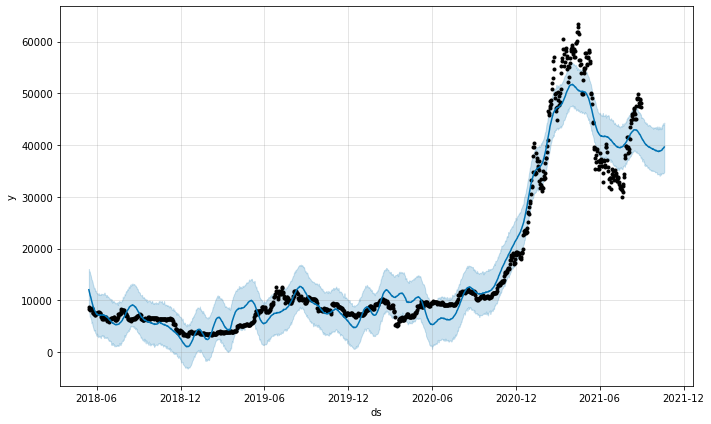

In [8]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=50)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


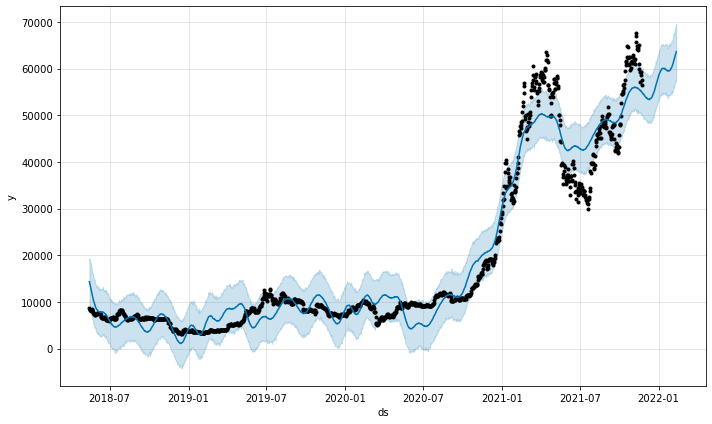

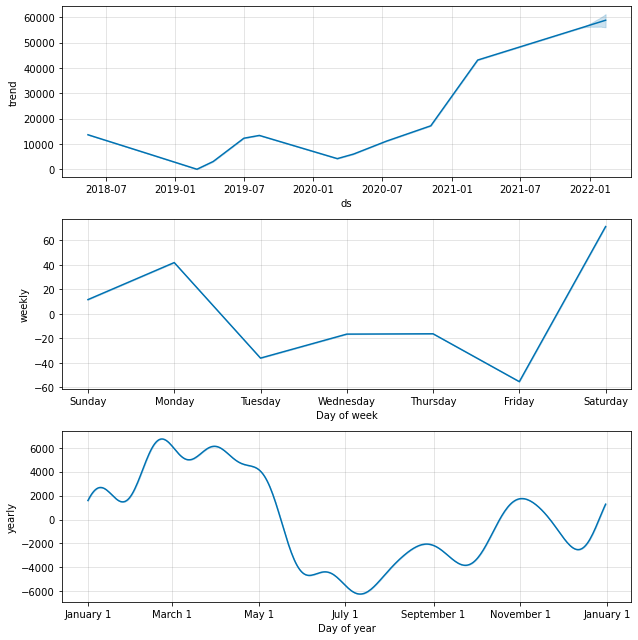

In [9]:
m = Prophet()
m.fit(btc)
future = m.make_future_dataframe(periods=80)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)



## Add regressor

In [10]:
sent1=df_lr.resample('d').sum()[['num_comments','score','polarity_lr']]

In [11]:
btc.index=pd.to_datetime(btc.ds)

In [12]:
btc

,ds,y
ds,,
2018-05-15,2018-05-15,8639.965000
2018-05-16,2018-05-16,8299.077708
2018-05-17,2018-05-17,8295.688542
2018-05-18,2018-05-18,8090.684375
2018-05-19,2018-05-19,8257.043750
...,...,...
2021-11-19,2021-11-19,57169.139167
2021-11-20,2021-11-20,58640.880417
2021-11-21,2021-11-21,59204.600208


In [65]:
eval.get_ts_2axis(qa.head(10000).polarity_lr,btc.y,resample_period='4d',btc_transformation='diff')

In [66]:
eval.get_ts_2axis(sent1.polarity_lr,btc.y,resample_period='4d',btc_transformation='diff')

<AxesSubplot:>

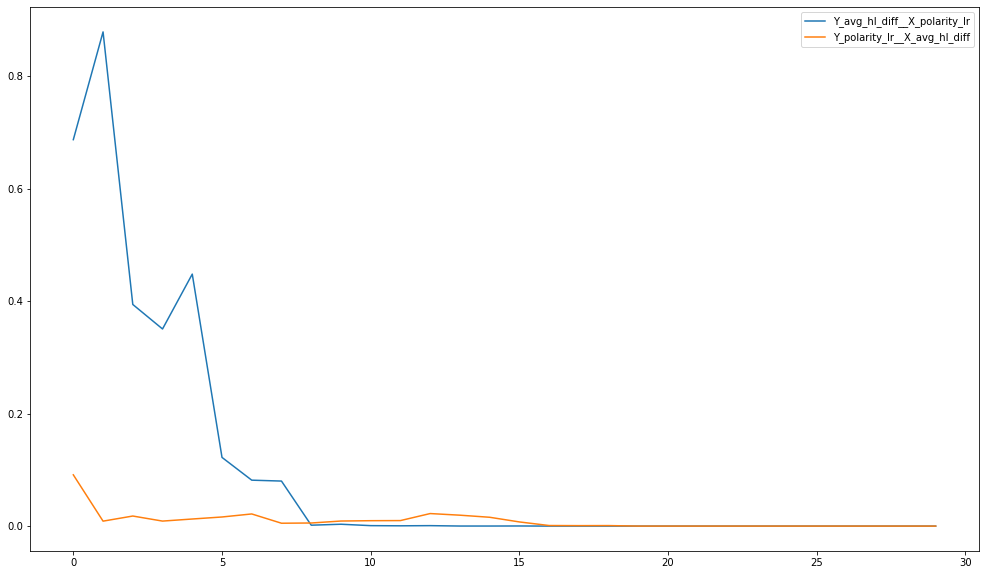

In [39]:

merres=eval.result_processing(qa.head(10000).polarity_lr.fillna(0),btc.rename(columns={'y':'avg_hl'}).avg_hl,resample_period='d')
eval.get_granger_causality(merres[['polarity_lr','avg_hl_diff']].dropna(),maxlag=30).plot(figsize=(17,10))

In [16]:
merres

,polarity_lr,avg_hl,avg_hl_diff,avg_hl_pct_change,sent_db_shift,sent_db_ptc_change
2019-02-13,-0.512880,3582.083958,NaN,NaN,NaN,NaN
2019-02-14,0.000000,3569.421250,-12.662708,-0.003535,-0.512880,-1.000000
2019-02-15,0.000000,3570.422083,1.000833,0.000280,0.000000,NaN
2019-02-16,0.000000,3587.027292,16.605208,0.004651,0.000000,NaN
2019-02-17,0.000000,3583.670625,-3.356667,-0.000936,0.000000,NaN
...,...,...,...,...,...,...
2021-06-27,-1.423812,32849.404583,1349.501250,0.042841,3.893686,-1.365672
2021-06-28,0.964262,34465.523750,1616.119167,0.049198,-1.423812,-1.677240
2021-06-29,1.008338,35427.257917,961.734167,0.027904,0.964262,0.045710
2021-06-30,7.081093,34994.297292,-432.960625,-0.012221,1.008338,6.022542


In [17]:
pin=merres[['polarity_lr','avg_hl_diff','avg_hl_pct_change','avg_hl']].dropna().reset_index().\
    rename(columns={'index':'ds','avg_hl':'y'})


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


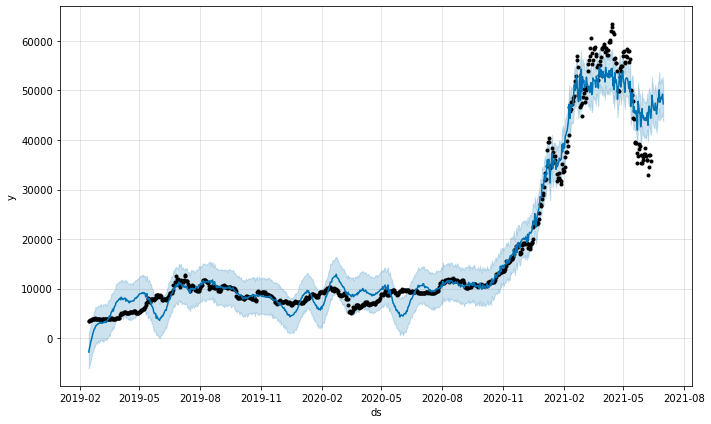

In [18]:


m = Prophet()
m.add_regressor('polarity_lr')
m.add_regressor('avg_hl_diff')
m.add_regressor('avg_hl_pct_change')
m.fit(pin.head(850))
forecast = m.predict(pin.drop(columns="y"))

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


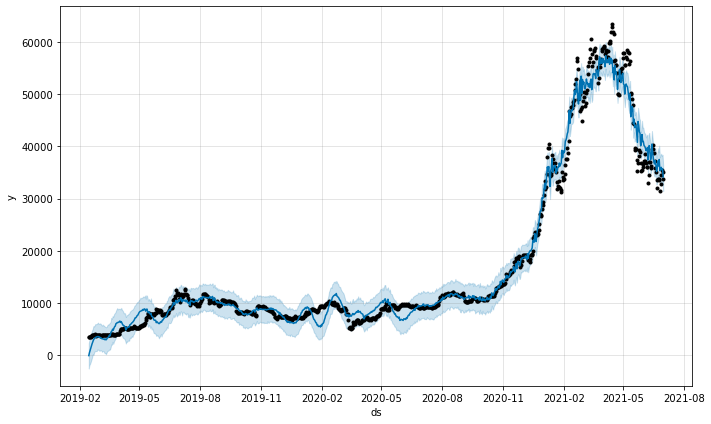

In [64]:


m = Prophet()
m.add_regressor('polarity_lr')
m.add_regressor('avg_hl_diff')
m.add_regressor('avg_hl_pct_change')
m.fit(pin.head(8550))
forecast = m.predict(pin.drop(columns="y"))

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)


### Cross Validation

In [57]:
from fbprophet.diagnostics import cross_validation
#df_cv = cross_validation(m, initial='730 days', period='15 days', horizon = '90 days')

cutoffs = pd.to_datetime(['2020-11-01', '2021-02-01', '2021-04-01'])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='90 days')



100%|██████████| 3/3 [00:06<00:00,  2.29s/it]


In [58]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,5.900012e+06,2428.994007,1832.693846,0.063836,0.046037,0.407407
1,10 days,8.001796e+06,2828.744675,2131.613975,0.072547,0.046037,0.407407
2,11 days,1.049798e+07,3240.058016,2495.781877,0.083538,0.049141,0.333333
3,12 days,1.324483e+07,3639.345058,2846.082728,0.094831,0.079339,0.259259
4,13 days,1.606355e+07,4007.935378,3209.670103,0.105563,0.128513,0.222222


C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\fbprophet\plot.py:526: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\fbprophet\plot.py:527: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



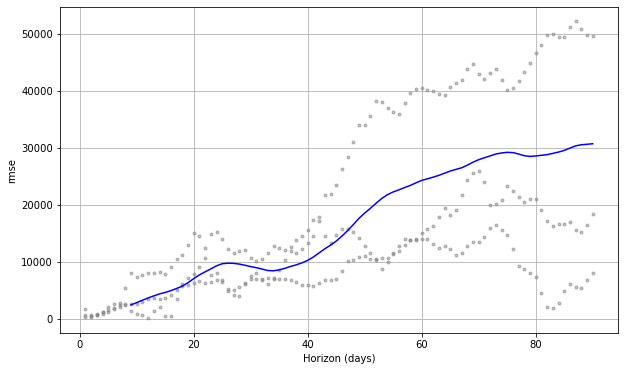

In [59]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')


# Normalization

## Title + Body

In [10]:
df=top.copy()
df.award_count=df.award_count.replace('Empty',0)
df.award_coin_price=df.award_coin_price.replace('Empty',0)
df['kpi1']=df.apply(lambda row: row['award_count']*row['award_coin_price'] if type(row['award_count'])==int
                                        else sum(np.multiply(np.array(list(row['award_count'])),np.array(list(row['award_coin_price'])))),axis=1)

top_authors=df[df.author!='[deleted]'].sort_values(by='kpi1',ascending=False).head(1000).author.unique().tolist()
s=df[df.author.isin(top_authors)]
s.selftext=s.selftext.fillna(' ')
s.title=s.title.fillna(' ')
s['all_text']=s.title+' '+s.selftext

## Text Processing

In [48]:
# Import spaCy and load the language library
import spacy

nlp = spacy.load('en_core_web_sm')

def text_processing_spacy(text):
    # Create a Doc object
    doc = nlp(text)
    token_list = []
    # collect each token separately with their POS Tag, dependencies and lemma
    for token in doc:
        output = [token.text, token.pos_, token.dep_,token.lemma_]
        token_list.append(output)
    # create DataFrame using data 
    dfnew = pd.DataFrame(token_list, columns =['Word', 'POS Tag', 'Dependencies', 'Lemmatized Word']) 

    df_nopunct = dfnew[dfnew['POS Tag']!='PUNCT']

    lemma_word = df_nopunct['Lemmatized Word'].values.tolist()
    stopword = nlp.Defaults.stop_words
    # Add the word to the set of stop words. Use lowercase!
    nlp.Defaults.stop_words.add('btw')
    is_stopword_list = []
    for word in lemma_word:
        is_stopword = nlp.vocab[word].is_stop
        is_stopword_list.append(is_stopword)
    df_nopunct["is_stopword"] = is_stopword_list
    df_nopunct
    clean_df = df_nopunct[df_nopunct["is_stopword"]==False]
    clean_list = clean_df["Lemmatized Word"].values.tolist()
    retout=' '.join(clean_list)
    return retout

In [53]:
s['all_text_clean']=s.all_text.progress_apply(text_processing_spacy)

  0%|          | 0/12031 [00:00<?, ?it/s]C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 12031/12031 [02:37<00:00, 76.22it/s] 
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Applying FinBert

In [67]:
#from CryptoSent.cs_models.finbertlong import fin_bert_long
from CryptoSent.cs_models.finbert import fin_bert


In [72]:
s['all_text_clean_capped']=s.all_text_clean.apply(lambda x: ' '.join(x.split()[:100]))
s['fin_bert']=s.all_text_clean_capped.progress_apply(fin_bert)

C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 14%|█▍        | 1708/12031 [01:46<10:45, 15.98it/s]


RuntimeError: The size of tensor a (786) must match the size of tensor b (512) at non-singleton dimension 1

# Emojis Normalized


In [ ]:
emojis=['🚀','✅','✔️','✨','⭐','🔥']
s.all_text_clean.str.contains('|'.join(emojis),case=False)

In [82]:
p=r'C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\Main Dataset\submissions.pickle'
df_raw=pd.read_pickle(p)

# selecting btc only
dfbtc=df_raw[df_raw.subreddit=='Bitcoin']


In [85]:
dfbtc.selftext=dfbtc.selftext.fillna(' ')
dfbtc.title=dfbtc.title.fillna(' ')
dfbtc['all_text']=dfbtc.title+' '+dfbtc.selftext

C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
emojis=['🚀','✅','✔️','✨','⭐','🔥']
dfbtc.loc[dfbtc.all_text.str.contains('|'.join(emojis),case=False),'pos_emoji']=True
dfbtc.pos_emoji=dfbtc.pos_emoji.fillna(False)


C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [112]:
emjres=dfbtc[['pos_emoji','id']].resample('d').agg({'pos_emoji': np.sum, 'id': 'count'})
emjres['emoji_subs_ratio']=(emjres.pos_emoji/emjres.id)*100

In [115]:
eval.get_ts_2axis(emjres.emoji_subs_ratio,btc.avg_hl,resample_period='w',btc_transformation='pct_change')

In [124]:
from datetime import datetime
def result_processing2(sentiment,coin_price,resample_period='d'):
    sdmin=datetime.strftime(sentiment.index.min(),'%Y-%m-%d')
    sdmax=datetime.strftime(sentiment.index.max(),'%Y-%m-%d')
    sent=sentiment.resample(resample_period).sum()
    btc=coin_price[sdmin:sdmax].resample(resample_period).mean()
    merres=pd.concat([sent,btc],axis=1)
    merres.loc[:,'avg_hl_diff']=merres.avg_hl.diff()
    merres.loc[:,'avg_hl_pct_change']=merres.avg_hl.pct_change()
    merres.loc[:,'sent_db_shift']=sent.shift(1)
    merres.loc[:,'sent_db_ptc_change']=sent.pct_change()
    return merres


<AxesSubplot:>

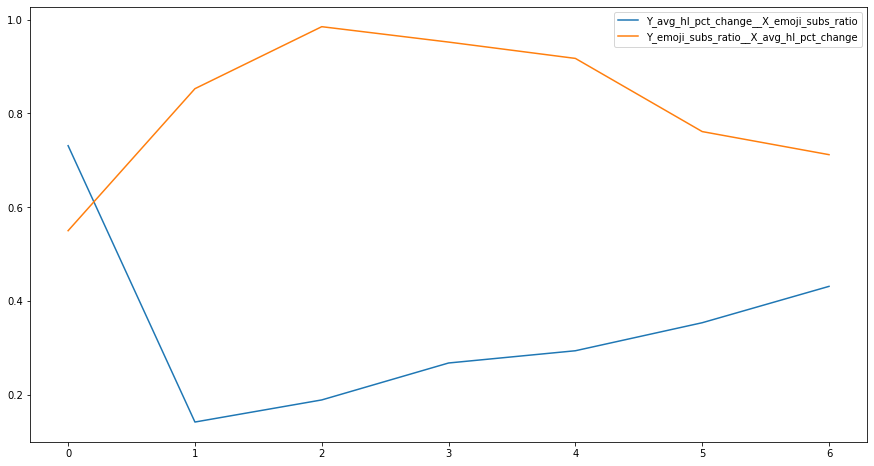

In [125]:
res=result_processing2(emjres.emoji_subs_ratio,btc.avg_hl,resample_period='d')
inm=res[['emoji_subs_ratio','avg_hl_pct_change']].dropna()
eval.get_granger_causality(inm,maxlag=7).plot(figsize=(15,8))

In [30]:
s['all_text_capped']=s.all_text.apply(lambda x: ' '.join(x.split()[:140]))

C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
s['distil_bert']=s.title.progress_apply(cm.distil_bert)

100%|██████████| 16227/16227 [06:17<00:00, 42.96it/s]
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
s['fin_bert']=s.title.progress_apply(cm.fin_bert)

100%|██████████| 16227/16227 [13:03<00:00, 20.72it/s]
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
s['pos']=s.fin_bert.apply(lambda x: x[0])
s['neg']=s.fin_bert.apply(lambda x: x[1])
s['neut']=s.fin_bert.apply(lambda x: x[2])

s['neg_distil']=s.distil_bert.apply(lambda x: x[0])
s['post_distil']=s.distil_bert.apply(lambda x: x[1])
top=s.copy()

C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

<AxesSubplot:xlabel='created'>

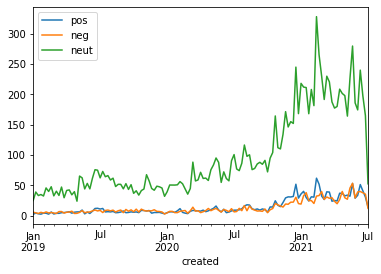

In [60]:
top[['pos','neg','neut']].resample('w').sum().plot()

<AxesSubplot:xlabel='created'>

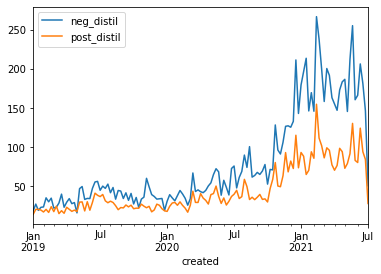

In [58]:
top[['neg_distil','post_distil']].resample('w').sum().plot()

In [51]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [187]:
dchunk='d'
a=top.resample(dchunk).sum()[['neg','pos','neut']]
btc_price=pd.read_csv(r"C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\other\coin_Bitcoin.csv")
btc_price.Date=pd.to_datetime(btc_price.Date)
btc_price=btc_price.set_index('Date')
btc_price['avg_price']=(btc_price.High+btc_price.Low)/2

btc_price_avg=btc_price.resample(dchunk).mean().loc['2019':'2021-06']['avg_price']

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])



fig.add_trace(
    go.Scatter(x=a.index, y=(a.pos-a.neg), name="FinBert Sentiment"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=btc_price_avg.index, y=btc_price_avg.diff(), name="Bit Coin Avg"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="BTC vs Sentiment Model "
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Polarity </b>", secondary_y=False)
fig.update_yaxes(title_text="<b>BTC Price</b>", secondary_y=True)

fig.show()

In [188]:
btc=btc_price_avg.diff().dropna()

In [196]:
gc=pd.concat([btc,
((top.post_distil-top.neg_distil).resample('d').sum()).rename('distil_bert'),
(a.pos-a.neg).tail(-1).rename('fin_bert')],axis=1).dropna()

In [203]:
(a.pos-a.neg).rename('fin_bert')

created
2019-01-01   -0.390011
2019-01-02   -3.064867
2019-01-03   -0.000574
2019-01-04   -0.054681
2019-01-05    0.376955
                ...   
2021-06-26   -1.671397
2021-06-27   -2.057088
2021-06-28   -0.038014
2021-06-29   -2.449407
2021-06-30    4.744237
Freq: D, Name: fin_bert, Length: 912, dtype: float64

In [197]:
gc

,avg_price,distil_bert,fin_bert
2019-01-02,103.622851,-2.986790,-3.064867
2019-01-03,-1.741384,0.730157,-0.000574
2019-01-04,-56.059902,0.933188,-0.054681
2019-01-05,46.007512,-0.163784,0.376955
2019-01-06,89.003642,-1.866696,-0.337447
...,...,...,...
2021-06-26,-2008.021437,-8.237820,-1.671397
2021-06-27,1952.897758,-9.218547,-2.057088
2021-06-28,1197.041590,-11.315186,-0.038014
2021-06-29,836.314113,-10.208426,-2.449407


In [198]:
grangercausalitytests(gc[['fin_bert','avg_price']],maxlag=4);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=45.9003 , p=0.0000  , df_denom=907, df_num=1
ssr based chi2 test:   chi2=46.0521 , p=0.0000  , df=1
likelihood ratio test: chi2=44.9247 , p=0.0000  , df=1
parameter F test:         F=45.9003 , p=0.0000  , df_denom=907, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=24.1487 , p=0.0000  , df_denom=904, df_num=2
ssr based chi2 test:   chi2=48.5645 , p=0.0000  , df=2
likelihood ratio test: chi2=47.3117 , p=0.0000  , df=2
parameter F test:         F=24.1487 , p=0.0000  , df_denom=904, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=17.9103 , p=0.0000  , df_denom=901, df_num=3
ssr based chi2 test:   chi2=54.1484 , p=0.0000  , df=3
likelihood ratio test: chi2=52.5953 , p=0.0000  , df=3
parameter F test:         F=17.9103 , p=0.0000  , df_denom=901, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=15.3204 , p=0.0000  

In [199]:
grangercausalitytests(gc[['avg_price','fin_bert']],maxlag=4);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0256  , p=0.8729  , df_denom=907, df_num=1
ssr based chi2 test:   chi2=0.0257  , p=0.8726  , df=1
likelihood ratio test: chi2=0.0257  , p=0.8726  , df=1
parameter F test:         F=0.0256  , p=0.8729  , df_denom=907, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8538  , p=0.0080  , df_denom=904, df_num=2
ssr based chi2 test:   chi2=9.7612  , p=0.0076  , df=2
likelihood ratio test: chi2=9.7092  , p=0.0078  , df=2
parameter F test:         F=4.8538  , p=0.0080  , df_denom=904, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6809  , p=0.0118  , df_denom=901, df_num=3
ssr based chi2 test:   chi2=11.1286 , p=0.0111  , df=3
likelihood ratio test: chi2=11.0609 , p=0.0114  , df=3
parameter F test:         F=3.6809  , p=0.0118  , df_denom=901, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6502  , p=0.0321  

In [136]:
print('Negative')
adf_test(a.neg)
print('Positive')
adf_test(a.pos)
print('Neutural')
adf_test(a.neut)

Negative
ADF Statistics: 0.658092
p-value: 0.988963
Critical values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
Positive
ADF Statistics: -0.634765
p-value: 0.862931
Critical values:
	1%: -3.485
	5%: -2.885
	10%: -2.579
Neutural
ADF Statistics: -0.875673
p-value: 0.795878
Critical values:
	1%: -3.485
	5%: -2.885
	10%: -2.579


In [137]:

from statsmodels.tsa.stattools import kpss

def kpss_test(df):    
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
        
print('KPSS Test: Apple time series')
kpss_test(a['pos'])
print('KPSS Test: Walmart time series')
kpss_test(a['neg'])
print('KPSS Test: Tesla time series')
kpss_test(a['neut'])

KPSS Test: Apple time series
KPSS Statistic: 1.4822883362170491
p-value: 0.01
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Walmart time series
KPSS Statistic: 1.429694166443776
p-value: 0.01
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Tesla time series
KPSS Statistic: 1.5218360017886652
p-value: 0.01
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\statsmodels\tsa\stattools.py:2012: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\statsmodels\tsa\stattools.py:2012: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\statsmodels\tsa\stattools.py:2012: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [179]:
sdf=top[top.score>200]

<AxesSubplot:xlabel='created'>

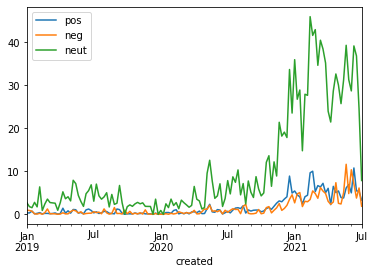

In [181]:
sdf[['pos','neg','neut']].resample('w').sum().plot()

<AxesSubplot:xlabel='created'>

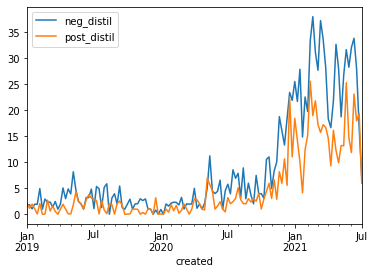

In [182]:
sdf[['neg_distil','post_distil']].resample('w').sum().plot()

In [183]:
dchunk='w'
a=sdf.resample(dchunk).sum()[['neg','pos','neut']]
btc_price=pd.read_csv(r"C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\other\coin_Bitcoin.csv")
btc_price.Date=pd.to_datetime(btc_price.Date)
btc_price=btc_price.set_index('Date')
btc_price['avg_price']=(btc_price.High+btc_price.Low)/2

btc_price_avg=btc_price.resample(dchunk).mean().loc['2019':'2021-06']['avg_price']

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])



fig.add_trace(
    go.Scatter(x=a.index, y=(a.pos-a.neg), name="FinBert Sentiment"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=btc_price_avg.index, y=btc_price_avg.diff(), name="Bit Coin Avg"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="BTC vs Sentiment Model "
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Polarity </b>", secondary_y=False)
fig.update_yaxes(title_text="<b>BTC Price</b>", secondary_y=True)

fig.show()

In [184]:
gc=pd.concat([btc,
((top.post_distil-top.neg_distil).resample('w').sum()).rename('distil_bert'),
(a.pos-a.neg).rename('fin_bert')],axis=1).dropna()

In [185]:
grangercausalitytests(gc[['fin_bert','avg_price']],maxlag=4);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8808  , p=0.3498  , df_denom=125, df_num=1
ssr based chi2 test:   chi2=0.9020  , p=0.3423  , df=1
likelihood ratio test: chi2=0.8988  , p=0.3431  , df=1
parameter F test:         F=0.8808  , p=0.3498  , df_denom=125, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1634  , p=0.8494  , df_denom=122, df_num=2
ssr based chi2 test:   chi2=0.3402  , p=0.8436  , df=2
likelihood ratio test: chi2=0.3397  , p=0.8438  , df=2
parameter F test:         F=0.1634  , p=0.8494  , df_denom=122, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7110  , p=0.5473  , df_denom=119, df_num=3
ssr based chi2 test:   chi2=2.2586  , p=0.5205  , df=3
likelihood ratio test: chi2=2.2386  , p=0.5244  , df=3
parameter F test:         F=0.7110  , p=0.5473  , df_denom=119, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4105  , p=0.2348  

In [186]:
grangercausalitytests(gc[['avg_price','fin_bert']],maxlag=4);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9973  , p=0.3199  , df_denom=125, df_num=1
ssr based chi2 test:   chi2=1.0212  , p=0.3122  , df=1
likelihood ratio test: chi2=1.0172  , p=0.3132  , df=1
parameter F test:         F=0.9973  , p=0.3199  , df_denom=125, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5549  , p=0.5756  , df_denom=122, df_num=2
ssr based chi2 test:   chi2=1.1552  , p=0.5612  , df=2
likelihood ratio test: chi2=1.1500  , p=0.5627  , df=2
parameter F test:         F=0.5549  , p=0.5756  , df_denom=122, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8288  , p=0.1456  , df_denom=119, df_num=3
ssr based chi2 test:   chi2=5.8092  , p=0.1213  , df=3
likelihood ratio test: chi2=5.6792  , p=0.1283  , df=3
parameter F test:         F=1.8288  , p=0.1456  , df_denom=119, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9826  , p=0.1017  